In [ ]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import random

In [ ]:
#this was created because Google Colab does not allow cv2.imshow, so must patch by cv2_imshow.  
#If we switch over to regular jupyter notebook not on Colab, we can change c2_imshow to cv2.imshow.  
from google.colab.patches import cv2_imshow #only used when running in Google Colab 
def my_imshow(title, img ):
  print(title)
  cv2_imshow(img) #should be changed to c2.imshow when not in Colab

In [ ]:
path = ""
fileName = path + "digits.png" 

#RGB images in BGR order in OpenCV
image = cv2.imread(fileName, cv2.IMREAD_COLOR)

# Print error message if image is null
if image is None:
    print('Could not read image')
else: 
    print("Image file read success...")

Image file read success...


In [ ]:
# cut out each digit as a labeled dataset and rescale all images from 20 x 20 to 24 x 24.
sub_image = []
desired_dimension = (24, 24)
height, width = image.shape[:2]
print(height, width)
for i in range(height // 20):
    sub_image.append([])
    for j in range(width // 20):
        sub_image[-1].append(cv2.resize(image[i*20:(i+1)*20, j*20:(j+1)*20], desired_dimension))

# Convert sub_image to a numpy array
sub_image = np.array(sub_image)

# Create a 50x100 array and initialize it to -1
label = np.full((50, 100), -1)

# Fill the array with alternating values of 0-9
for i in range(10):
    label[i*5:(i+1)*5, :] = i

# Split sub_image into training and testing sets
sub_train, sub_test, train_label, test_label = train_test_split(sub_image, label, test_size=0.2, random_state=42)
flat_train_label = train_label.flatten()
flat_test_label = test_label.flatten()
print(flat_train_label.shape)

1000 2000
(4000,)


In [ ]:
# Convert X_train and X_test to float and scale them
float_train = np.float32(sub_train) / 255.0
float_test = np.float32(sub_test) / 255.0

# Calculate the gradients for the training and testing sets
Gx_train = []
Gy_train = []

for row in float_train:
    for img in row:
        Gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
        Gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
        Gx_train.append(Gx)
        Gy_train.append(Gy)

Gx_train = np.array(Gx_train)
Gy_train = np.array(Gy_train)

print(Gx_train.shape, Gy_train.shape)

(4000, 24, 24, 3) (4000, 24, 24, 3)


In [ ]:
# Calculate gradient magnitude and direction ( in degrees )
magnitude, angle_degrees = cv2.cartToPolar(Gx_train, Gy_train, angleInDegrees=True)
print(magnitude.shape, angle_degrees.shape)
# You can then do the histogram yourself ... it might be easier.

(4000, 24, 24, 3) (4000, 24, 24, 3)


In [ ]:
'''
HOG using OpenCV. 

win_size – Detection window size. Align to block size and block stride.
block_size – Block size in pixels. Align to cell size. Only (16,16) is supported for now.
block_stride – Block stride. It must be a multiple of cell size.
cell_size – Cell size. Only (8, 8) is supported for now.
nbins – Number of bins. Only 9 bins per cell are supported for now.
win_sigma – Gaussian smoothing window parameter.
threshold_L2hys – L2-Hys normalization method shrinkage.
gamma_correction – Flag to specify whether the gamma correction preprocessing is required or not.
nlevels – Maximum number of detection window increases.
'''
winSize = desired_dimension
blockSize = (16,16) #OpenCV only supports 16 x 16 block sizes 
blockStride = (8,8) #multiple of cell size. Here it is multiple of 1.  
cellSize = (8,8) #OpenCV only supports 8x8 cell size. That means each Block will have 4 histograms
nbins = 9 #OpenCV only supports 9 orientations per cell.  That means 1 block has 4 x 9 = 36 features
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection)
#compute(img[, winStride[, padding[, locations]]]) -> descriptors
winStride = (8,8)
padding = (8,8)
locations = ((0,0),) #we run it at only one location of image (entire image).  Can be used to run at sub-image parts. 

train_hog_feature = np.zeros((len(sub_train), len(sub_train[0]), 4*4*nbins))
#print(hog_feature.shape)
for i in range(len(sub_train)):
    for j in range(len(sub_train[i])):
        feature_vector = hog.compute(sub_train[i][j],winStride,padding,locations)
        feature_vector = feature_vector.reshape(-1) # Flatten the 3D array to 1D array
        train_hog_feature[i][j] = feature_vector

train_hog_feature = train_hog_feature.reshape((train_hog_feature.shape[0]*train_hog_feature.shape[1], train_hog_feature.shape[2]))
#print("HOG feature: \n", train_hog_feature)
number_of_train_features = train_hog_feature.shape
# There are 7 horizontal and 15 vertical blue windows, making a total of 7 x 15 = 105 positions.
# Each 16×16 block is represented by 4 of 8 x 8 blocks. Each block is 9 histogram values. 
# Each 16x16 block has 4 x 9 = 36×1 feature vector. 
# The feature is a concatenation of 105 such features to get 
# a vector of dimension 3,780 from 105 x 36.  

print("Number of train Features: ", number_of_train_features)
# print("This is from 9 histo values per cell x 4 cells per 16x16 block x (7x15) blocks per image: ", 9*4*7*15)

test_hog_feature = np.zeros((len(sub_test), len(sub_test[0]), 4*4*nbins))
# print(hog_feature.shape)
for i in range(len(sub_test)):
    for j in range(len(sub_test[i])):
        feature_vector = hog.compute(sub_test[i][j],winStride,padding,locations)
        feature_vector = feature_vector.reshape(-1) # Flatten the 3D array to 1D array
        test_hog_feature[i][j] = feature_vector

test_hog_feature = test_hog_feature.reshape((test_hog_feature.shape[0]*test_hog_feature.shape[1], test_hog_feature.shape[2]))
# print("HOG feature: \n", test_hog_feature)
number_of_test_features = test_hog_feature.shape
print("Number of test Features: ", number_of_test_features)

Number of train Features:  (4000, 144)
Number of test Features:  (1000, 144)


In [ ]:
# Convert sub_train images to grayscale and flatten them
sub_train_gray = []
for row in sub_train:
    for img in row:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_img_flat = gray_img.flatten()
        sub_train_gray.append(gray_img_flat)

# Convert sub_test images to grayscale and flatten them
sub_test_gray = []
for row in sub_test:
    for img in row:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_img_flat = gray_img.flatten()
        sub_test_gray.append(gray_img_flat)

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_hog_feature, flat_train_label)
HOG_K5 = knn_classifier.predict(test_hog_feature)

accuracy = sum(HOG_K5 == flat_test_label) / len(flat_test_label)
print("HOG_K5 Accuracy:", accuracy)

knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_classifier.fit(train_hog_feature, flat_train_label)
HOG_K1 = knn_classifier.predict(test_hog_feature)

accuracy = sum(HOG_K1 == flat_test_label) / len(flat_test_label)
print("HOG_K1 Accuracy:", accuracy)

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(sub_train_gray, flat_train_label)
GRAY_K5 = knn_classifier.predict(sub_test_gray)

accuracy = sum(GRAY_K5 == flat_test_label) / len(flat_test_label)
print("GRAY_K5 Accuracy:", accuracy)

knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_classifier.fit(sub_train_gray, flat_train_label)
GRAY_K1 = knn_classifier.predict(sub_test_gray)

accuracy = sum(GRAY_K5 == flat_test_label) / len(flat_test_label)
print("GRAY_K1 Accuracy:", accuracy)

HOG_K5 Accuracy: 0.956
HOG_K1 Accuracy: 0.949
GRAY_K5 Accuracy: 0.924
GRAY_K1 Accuracy: 0.924


Selected Sub-Image with Bounding Box


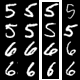

Test-Image


Test-Image


Test-Image


Test-Image


In [ ]:
desired_dimension = (24, 24)
row_start = ((random.randint(0, 8)*5) + 3) * 20
col_start = random.randint(0, 94) * 20
cut_image = image[row_start:row_start+(20*4), col_start:col_start+(20*4)]

sub_cut = []
desired_dimension = (24, 24)
height, width = cut_image.shape[:2]
for i in range(height // 20):
    sub_cut.append([])
    for j in range(width // 20):
        sub_cut[-1].append(cv2.resize(cut_image[i*20:(i+1)*20, j*20:(j+1)*20], desired_dimension))

first_label = int(((row_start/20)-3)/5)
ran_col = random.randint(0, 3)
test_cut = []
train_cut = []
test_cut_label = [first_label, first_label, first_label+1, first_label+1]
train_cut_label = [first_label, first_label, first_label, first_label, first_label, first_label, first_label+1, first_label+1, first_label+1, first_label+1, first_label+1, first_label+1]
for row in range(len(sub_cut)):
    for col in range(len(sub_cut[row])):
        if col == ran_col:
            test_cut.append(sub_cut[row][col])
            cv2.rectangle(cut_image, (ran_col*20, 0), ((ran_col*20)+20, 80), (255, 255, 255), 2)
        else:
            train_cut.append(sub_cut[row][col])

# Display the image with bounding box
my_imshow('Selected Sub-Image with Bounding Box', cut_image)
for img in test_cut:
    my_imshow('Test-Image', img)

In [ ]:
winSize = desired_dimension
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection)

winStride = (8,8)
padding = (8,8)
locations = ((0,0),)

train_cut_hog_feature = np.zeros((len(train_cut), 4*4*nbins))
for i in range(len(train_cut)):
    feature_vector = hog.compute(train_cut[i],winStride,padding,locations)
    feature_vector = feature_vector.reshape(-1)
    train_cut_hog_feature[i] = feature_vector


test_cut_hog_feature = np.zeros((len(test_cut), 4*4*nbins))
for i in range(len(test_cut)):
    feature_vector = hog.compute(test_cut[i],winStride,padding,locations)
    feature_vector = feature_vector.reshape(-1) # Flatten the 3D array to 1D array
    test_cut_hog_feature[i] = feature_vector

print(train_cut_hog_feature.shape, len(train_cut_label))
knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_classifier.fit(train_cut_hog_feature, train_cut_label)
HOG_K1 = knn_classifier.predict(test_cut_hog_feature)

accuracy = sum(HOG_K1 == test_cut_label) / len(test_cut_label)
print("HOG_K1 Accuracy:", accuracy)

(12, 144) 12
HOG_K1 Accuracy: 1.0


In [ ]:
path = ""
fileName51 = path + "5.1.png" 
fileName52 = path + "5.2.png" 
fileName53 = path + "5.3.png" 
fileName54 = path + "5.4.png" 

#RGB images in BGR order in OpenCV
image51 = cv2.imread(fileName51, cv2.IMREAD_COLOR)
image51 = cv2.resize(image51, desired_dimension)
image52 = cv2.imread(fileName52, cv2.IMREAD_COLOR)
image52 = cv2.resize(image52, desired_dimension)
image53 = cv2.imread(fileName53, cv2.IMREAD_COLOR)
image53 = cv2.resize(image53, desired_dimension)
image54 = cv2.imread(fileName54, cv2.IMREAD_COLOR)
image54 = cv2.resize(image54, desired_dimension)

desired_dimension = (24, 24)
test_cut_label = [5, 5, 5, 5]
winSize = desired_dimension
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection)

winStride = (8,8)
padding = (8,8)
locations = ((0,0),)

my_imshow("imh51", image51)
my_imshow("imh52", image52)
my_imshow("imh53", image53)
my_imshow("imh54", image54)

train_cut_hog_feature = np.zeros((len(train_cut), 4*4*nbins))
for i in range(len(train_cut)):
    feature_vector = hog.compute(train_cut[i],winStride,padding,locations)
    feature_vector = feature_vector.reshape(-1)
    train_cut_hog_feature[i] = feature_vector

test_cut = [image51, image52, image53, image54]
test_cut_hog_feature = np.zeros((len(test_cut), 4*4*nbins))
for i in range(len(test_cut)):
    feature_vector = hog.compute(test_cut[i],winStride,padding,locations)
    feature_vector = feature_vector.reshape(-1) # Flatten the 3D array to 1D array
    test_cut_hog_feature[i] = feature_vector

print(train_cut_hog_feature.shape, len(train_cut_label))
knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_classifier.fit(train_cut_hog_feature, train_cut_label)
HOG_K1 = knn_classifier.predict(test_cut_hog_feature)

accuracy = sum(HOG_K1 == test_cut_label) / len(test_cut_label)
print("HOG_K1 Accuracy:", accuracy)

imh51


imh52


imh53


imh54


(12, 144) 12
HOG_K1 Accuracy: 1.0


In [ ]:
img = cv2.imread('digits.png', 0)

thresh = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)[1]

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=8)

images = []
labels = []
for i in range(1, num_labels):
    left, top, width, height, _ = stats[i]

    digit_img = img[top:top + height, left:left + width]

    resized_img = cv2.resize(digit_img, (24, 24))

    images.append(resized_img)
    labels.append(i // 500)

img_train, img_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

desired_dimension = (24, 24)
test_cut_label = [5, 5, 5, 5]
winSize = desired_dimension
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection)

train_features = np.array([hog.compute(cv2.resize(img, desired_dimension)) for img in img_train]).reshape(len(img_train), -1)

test_features = np.array([hog.compute(cv2.resize(img, desired_dimension)) for img in img_test]).reshape(len(img_test), -1)

knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_classifier.fit(train_features, y_train)

predictions = knn_classifier.predict(test_features)
accuracy = np.mean(predictions == y_test)

print("HOG_K1 Accuracy:", accuracy)

HOG_K1 Accuracy: 0.8204121687929342
